In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/from_pyupbit/solana.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,value
0,2021-10-15 15:10:00,159700.0,209900.0,159700.0,208000.0,117356.537345,2.397389e+10
1,2021-10-15 15:11:00,209300.0,235300.0,207950.0,229950.0,147587.208273,3.249029e+10
2,2021-10-15 15:12:00,233600.0,246050.0,220050.0,230050.0,146786.335554,3.501196e+10
3,2021-10-15 15:13:00,220700.0,230000.0,219300.0,219700.0,92228.730424,2.035467e+10
4,2021-10-15 15:14:00,219800.0,226100.0,219550.0,225000.0,67159.027880,1.501052e+10
...,...,...,...,...,...,...,...
1531895,2024-10-11 03:09:00,186200.0,186200.0,185900.0,185900.0,113.028530,2.101988e+07
1531896,2024-10-11 03:10:00,185900.0,186650.0,185850.0,186400.0,824.662403,1.534545e+08
1531897,2024-10-11 03:11:00,186400.0,186400.0,186300.0,186350.0,171.788741,3.201785e+07
1531898,2024-10-11 03:12:00,186400.0,186400.0,185750.0,185750.0,315.306614,5.860840e+07


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

In [7]:
timestep = 1

X = []
y = []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [8]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [9]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:len(X)]

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
38298/38298 [==============================] - 69s 2ms/step - loss: 7.0102e-05 - val_loss: 1.0820e-06
Epoch 2/20
38298/38298 [==============================] - 68s 2ms/step - loss: 1.5630e-06 - val_loss: 2.4966e-06
Epoch 3/20
38298/38298 [==============================] - 68s 2ms/step - loss: 1.3155e-06 - val_loss: 1.1687e-06
Epoch 4/20
38298/38298 [==============================] - 68s 2ms/step - loss: 1.1450e-06 - val_loss: 1.2976e-06
Epoch 5/20
38298/38298 [==============================] - 69s 2ms/step - loss: 1.0694e-06 - val_loss: 3.2379e-06
Epoch 6/20
38298/38298 [==============================] - 68s 2ms/step - loss: 1.0017e-06 - val_loss: 1.1340e-06
Epoch 7/20
38298/38298 [==============================] - 65s 2ms/step - loss: 9.4727e-07 - val_loss: 1.1393e-06
Epoch 8/20
38298/38298 [==============================] - 65s 2ms/step - loss: 8.9485e-07 - val_loss: 2.9611e-06
Epoch 9/20
38298/38298 [==============================] - 65s 2ms/step - loss: 8.6773e-07 - val_

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9575/9575 [==============================] - 5s 556us/step


In [16]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [17]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 350.62
Test RMSE: 489.23


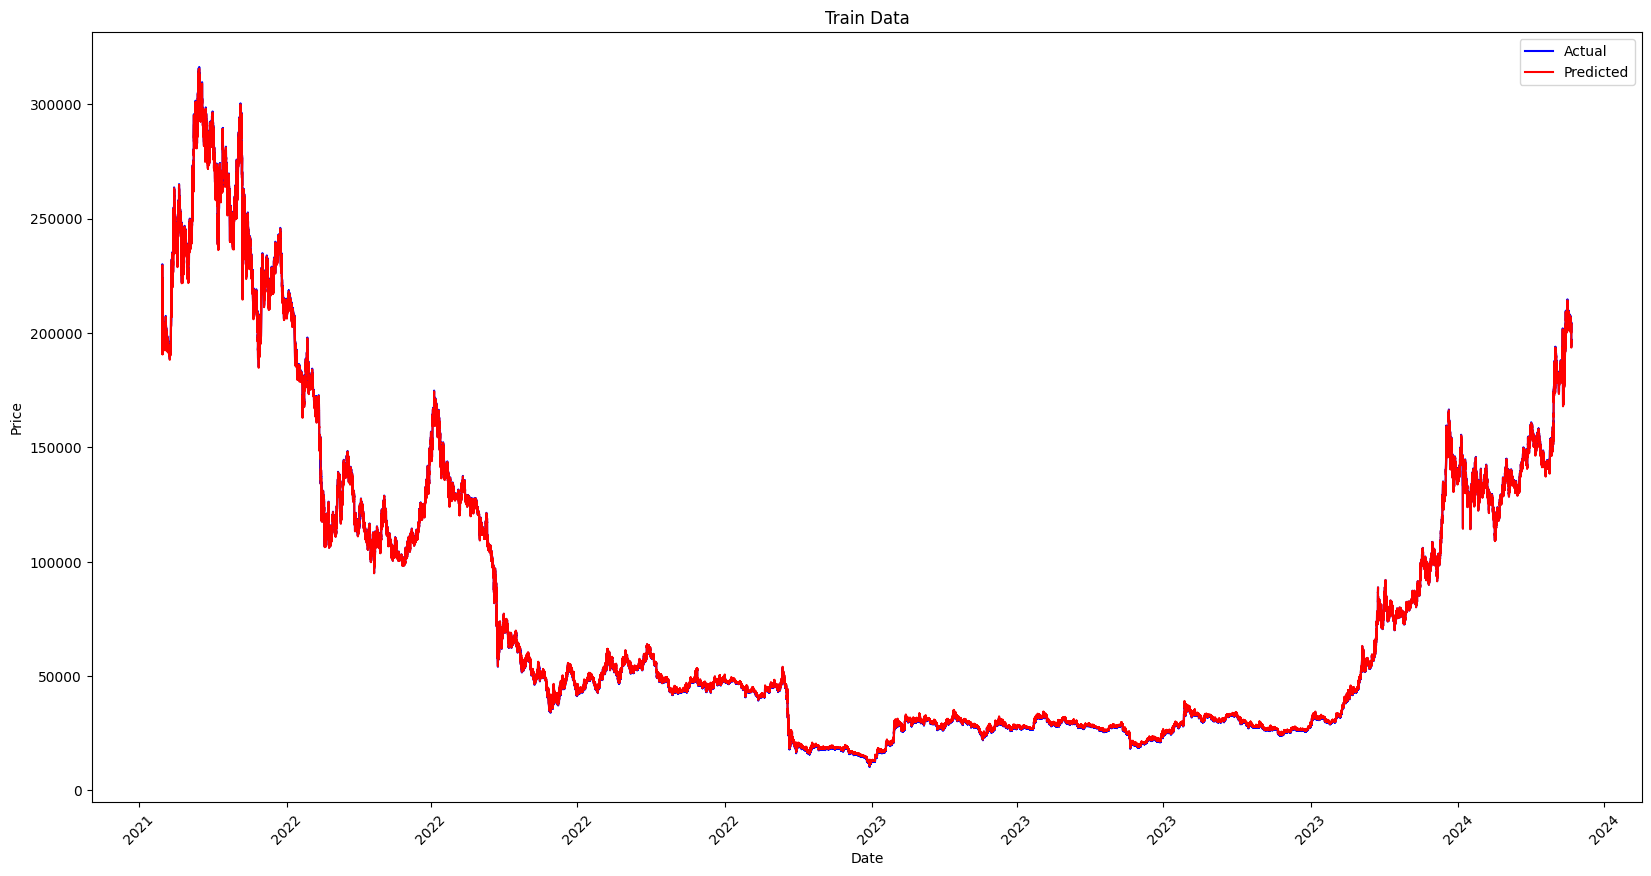

In [18]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

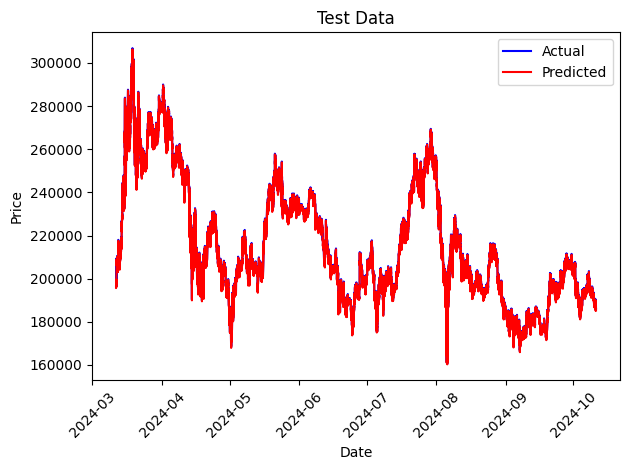

In [19]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [20]:
last_1_days = scaled_data[-timestep:]
X_predict = last_1_days.reshape(1, timestep, 1)

In [21]:
pred = model.predict(X_predict)
print(pred)

1/1 [==============================] - 0s 13ms/step
[[0.5727037]]


In [22]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))